# Install the required packages

In [20]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip3 install numpy
!pip3 install matplotlib

Cloning into 'visualime_guide'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 412.79 KiB | 1.70 MiB/s, done.
ERROR: Directory '//' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


# Import the required packages

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transformations to prepare the data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

1. ```transforms.ToTensor()``` converts the image to a tensor
2. ```transforms.Normalize((0.5,), (0.5,))``` normalizes the image

# Download the dataset

In [31]:
!mkdir data

testset = datasets.MNIST('data', download=True, train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%
2.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%
100.0%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Analyze the dataset

In [32]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


The batch size is 64 and the image size is 28x28 and the number of channels is 1 (grayscale)
The labels are the corresponding numbers for the images

# Download the model

In [33]:
# Adress: https://github.com/Bergschaf/visualime_guide/raw/master/models/mnist_model.pt
!wget https://github.com/Bergschaf/visualime_guide/raw/master/models/mnist_model.pt
model = torch.load("mnist_model.pt")

--2023-04-18 12:20:53--  https://github.com/Bergschaf/visualime_guide/raw/master/models/mnist_model.pt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Bergschaf/visualime_guide/master/models/mnist_model.pt [following]
--2023-04-18 12:20:53--  https://raw.githubusercontent.com/Bergschaf/visualime_guide/master/models/mnist_model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441271 (431K) [application/octet-stream]
Saving to: ‘mnist_model.pt.2’

mnist_model.pt.2    100%[===================>] 430.93K  1.67MB/s    in 0.3s

# Test the model on a single image

Predicted Digit = 2


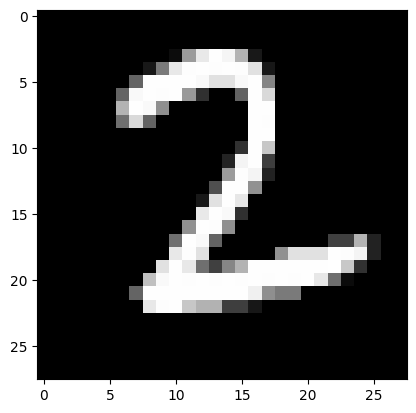

In [34]:
img = images[0]
img = img.view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

plt.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')

# Explain the classification with visualime

## Install and import visuallime

In [35]:
!pip3 install visualime
from visualime.explain import explain_classification, render_explanation


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


## Define helper Functions

In [36]:
def to_visualime(image: np.ndarray):
    """
     Converts an image of the shape [1,28,28] to the shape [28,28,3]
    """
    image = image.squeeze()
    image = np.stack((image, image, image), axis=2)
    return image

```to_visualime()``` converts the image to the shape [28,28,3] which is required by visualime

In [37]:
def predict(imgs: np.ndarray):
    """
    :param image: visualime RGB image of the shape [num_samples, 28,28,3]
    :return:
    """
    imgs = imgs[:, :, :, 0]
    predictions = np.zeros((imgs.shape[0], 10))
    for i in range(imgs.shape[0]):
        image = imgs[i]
        # convert the image to a tensor
        image = torch.from_numpy(image)
        image = image.view(1, 784)
        with torch.no_grad():
            prediction = model(image)
        predictions[i] = torch.exp(prediction).numpy()[0]
    return predictions


```predict()``` takes an image of the shape [num_samples, 28,28,3] (an array of visualime images) and returns the predictions of the model
This is required to explain the classification with visualime

## Explain the classification

In [40]:
img = images[5] # Choose an image

The network predicts:  7


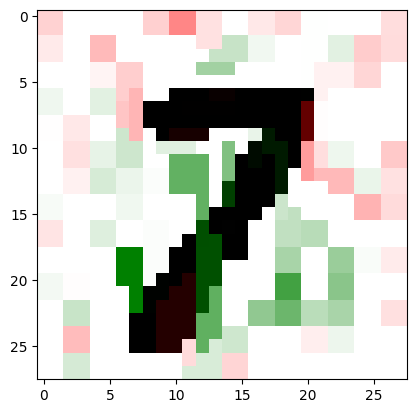

In [41]:
print("The network predicts: ", np.argmax(predict(np.array([to_visualime(img)]))))

segment_mask, segment_weights = explain_classification(image=to_visualime(img), predict_fn=predict, num_of_samples=512)

explanation = render_explanation(
        to_visualime(img),
        segment_mask,
        segment_weights,
        positive="green",
        negative="red",
        coverage=0.5,
        opacity=1,
    )

plt.imshow(explanation)
